In [40]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from keras.optimizers import Adam

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 800)

In [121]:
def createGap(df,start,end):

    #df = readData()
    l = len(df.index)
    if end>l:
        end = l
        
    for i in range(start,end):
        df['GlucoseValue'][i]=0
    
    
    return df

def detectGap(testing_data):

        l = []
        k = -1
        for i in testing_data['GlucoseValue']:
            k+=1
            if i==0:
                l.append(k)
        b = min(l)
        e = max(l)
        #print(b,e)
        gap=e-b
        # print("Gap detected!")
        return b,e,gap

def index_agreement(o,s):
        
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))

    return ia

In [147]:
df = pd.read_csv('GlucoCheck/Data/consolidatedDataForPackage.csv')     
df['Display Time'] = df['Display Time'].apply(lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
test_df = df[df['subjectId']=='1636-69-032']
res = df[df['subjectId']=='1636-69-032']
df.drop(['subjectId'], axis=1, inplace=True)
test_df.drop(['subjectId'], axis=1, inplace=True)
test_df = test_df.reset_index(drop=True)

In [148]:
test_df = createGap(test_df.copy(),1650,1655)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [149]:
b,e,g = detectGap(test_df)
b,e,g

(1650, 1654, 4)

In [150]:
# extracting only glucose values of the gap size before the gap occurs
test_before_gap = test_df[b-g-1:b]
df=df.append(test_before_gap)
test_before_gap

,Display Time,GlucoseValue
1645,2016-01-19 06:07:51,103.0
1646,2016-01-19 06:12:51,103.0
1647,2016-01-19 06:17:51,102.0
1648,2016-01-19 06:22:51,104.0
1649,2016-01-19 06:27:51,103.0


In [151]:
test_df = test_df[b-2:e+1]
res = res[b:e]
test_df = test_before_gap
test_df

,Display Time,GlucoseValue
1645,2016-01-19 06:07:51,103.0
1646,2016-01-19 06:12:51,103.0
1647,2016-01-19 06:17:51,102.0
1648,2016-01-19 06:22:51,104.0
1649,2016-01-19 06:27:51,103.0


In [152]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(columns=['Date', 'GV'])
new_data['Date'] = data['Display Time']
new_data['GV'] = data['GlucoseValue']

test = test_df.sort_index(ascending=True, axis=0)
test_data = pd.DataFrame(columns=['Date', 'GV'])
test_data['Date'] = test['Display Time']
test_data['GV'] = test['GlucoseValue']


In [153]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values

test_data.index = test_data.Date
test_data.drop('Date', axis=1, inplace=True)
test_set = test_data.values

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(dataset)
train = scaled_data


scaled_test = scaler.fit_transform(test_set)
valid = scaled_test

In [154]:
x_train,y_train=[],[]
for i in range(1,train.shape[0]):
    x_train.append(train[i-1:i,0])
    y_train.append(train[i,0])


In [155]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [156]:
model = Sequential()
model.add(LSTM(units=100,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=100))
model.add(Dropout(0.4))
model.add(Dense(1))
ADAM = Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=ADAM)
history = model.fit(x_train,y_train,epochs=30,batch_size=72,verbose=1,shuffle=False)


Epoch 1/30
316531/316531 [==============================] - 28s 90us/step - loss: 0.0013
Epoch 2/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.7299e-04
Epoch 3/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.6046e-04
Epoch 4/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.5986e-04
Epoch 5/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.6154e-04
Epoch 6/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.6151e-04
Epoch 7/30
316531/316531 [==============================] - 27s 86us/step - loss: 3.6092e-04
Epoch 8/30
316531/316531 [==============================] - 27s 84us/step - loss: 3.6078e-04
Epoch 9/30
316531/316531 [==============================] - 26s 83us/step - loss: 3.5823e-04
Epoch 10/30
316531/316531 [==============================] - 28s 87us/step - loss: 3.5851e-04
Epoch 11/30
316531/316531 [==============================] - 26s 83us/ste

In [157]:
x_test = []
for z in range(1,valid.shape[0]):
    x_test.append(valid[z-1:z,0])
#     y_test.append(valid[z,0])

x_test = np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [158]:
# len(x_test)

In [159]:
c = model.predict(x_test)

In [160]:
b = scaler.inverse_transform(c)


In [161]:

b

array([[102.99967 ],
       [102.99967 ],
       [102.05097 ],
       [103.888695]], dtype=float32)

In [172]:
res = pd.read_csv('GlucoCheck/Data/consolidatedDataForPackage.csv')     
res = res[res['subjectId']=='1636-69-032']
res = res[b:e]

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [[[102.99967 ]
 [102.99967 ]
 [102.05097 ]
 [103.888695]]] of <class 'numpy.ndarray'>

In [168]:
res["P"] = np.round(b)

res

,Display Time,GlucoseValue,subjectId,P
53105,2016-01-19 06:22:51,104.0,1636-69-032,103.0
53106,2016-01-19 06:27:51,103.0,1636-69-032,103.0
53107,2016-01-19 06:32:51,104.0,1636-69-032,102.0
53108,2016-01-19 06:37:51,90.0,1636-69-032,104.0


In [166]:
# res.drop(res.tail(3).index,inplace=True)

In [169]:
# 5
index_agreement(np.asarray(res.GlucoseValue),np.asarray(res.P))

0.32719665271966525

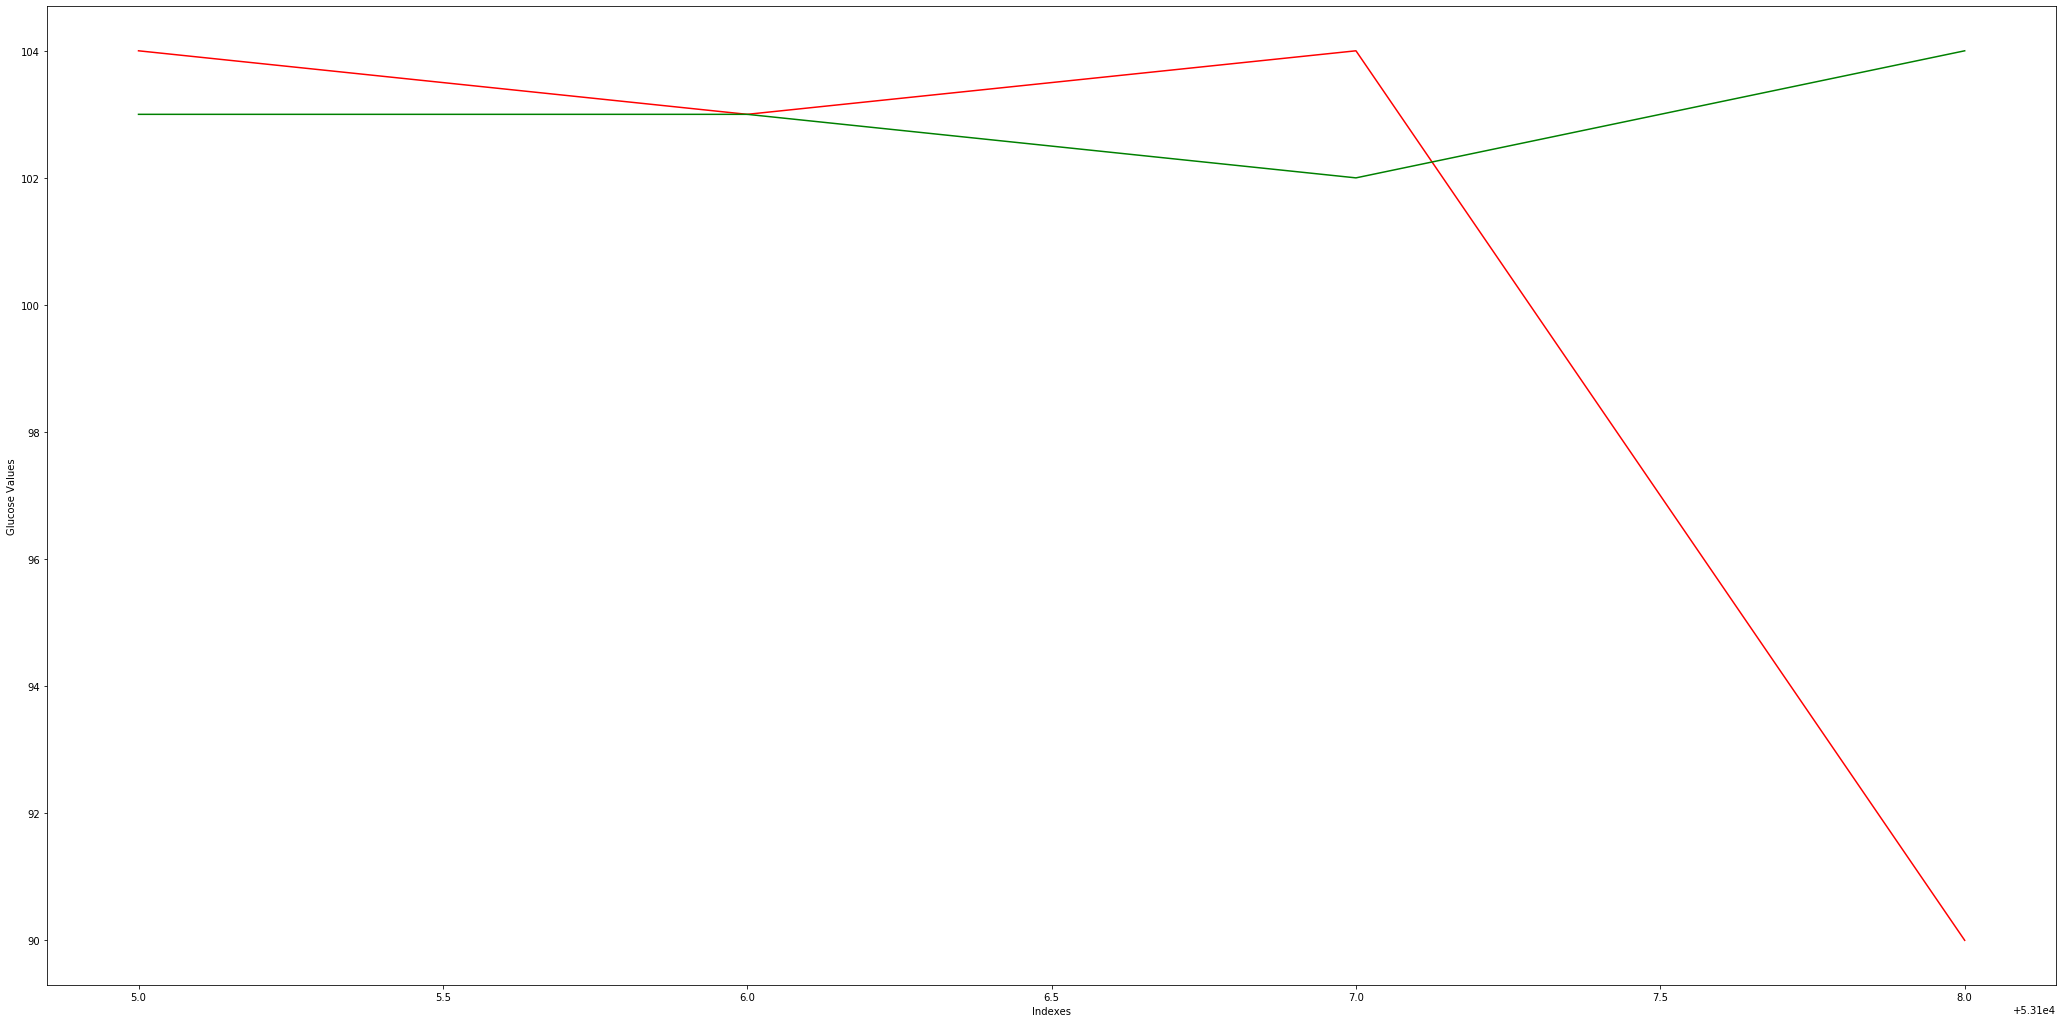

In [170]:
fig = plt.figure(figsize=(36, 18))
plt.plot(res['GlucoseValue'], color='red')
plt.plot(res['P'], color='green')

plt.xlabel('Indexes')
plt.ylabel('Glucose Values')
plt.show()